In [ ]:
import sys

sys.path.append(".")

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from torch.autograd import grad
from matplotlib.animation import FuncAnimation

torch.backends.cuda.matmul.allow_tf32 = (
    False # This is for Nvidia Ampere GPU architecture
)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
torch.manual_seed(1234)
np.random.seed(1234)

In [ ]:
class layer(nn.Module):
  def __init__(self, n_in, n_out, activation):
    super().__init__()
    self.layer = nn.Linear(n_in, n_out)
    self.activation = activation

  # forward method specifies how input data is processed through the layer
  def forward(self, x):
    x = self.layer(x)
    if self.activation:
      x = self.activation(x)
    return x

In [ ]:
# Define a deep Neural Network (DNN)
class DNN(nn.Module):
  def __init__(self, dim_in, dim_out, n_layer, n_node, ub, lb,
               activation=nn.Tanh()):
    super().__init__()
    # Initialize a list to store the layers of the neural network
    self.net = nn.ModuleList()

    # Add the input layer with specified input size, node count, and activation function
    self.net.append(layer(dim_in, n_node, activation))

    # Add the specified number of hidden layers with the same node count and activation function
    for _ in range(n_layer):
      self.net.append(layer(n_node, n_node, activation))

     # Add the output layer with specified output size and no activation function
    self.net.append(layer(n_node, dim_out, activation=None))

    # Store upper and lower bounds for input scaling
    self.ub = torch.tensor(ub, dtype=torch.float).to(device)
    self.lb = torch.tensor(lb, dtype=torch.float).to(device)

    # Apply Xavier initialization to the network weights
    self.net.apply(weights_init) # xavier initialization

  def forward(self, x):
    x = (x - self.lb) / (self.ub - self.lb) # Min-max scaling
    # Initialize the output with the scaled input
    out = x
    # Process the input through each layer in the network
    for layer in self.net:
      out = layer(out)
    return out


# Custom weight initialization method for the Xavier initialization
def weights_init(m):
  if isinstance(m, nn.Linear):
    torch.nn.init.xavier_uniform_(m.weight.data)
    torch.nn.init.zeros_(m.bias.data)

In [ ]:
# Define the number of points for initial condition, boundary condition, and collocation points
N_0 = 200
N_bc = 400
N_f = 10000

# Define the spatial and temporal domain boundaries
x_min = 0.0
x_max = 0.5
t_min = 0.0
t_max = 1.0

# Define upper and lower bounds for the input space
ub = np.array([x_max, t_max])
lb = np.array([x_min, t_min])

# Generate random points for the `initial condition, u(x, 0) = f(x)`
xt_0 = np.random.uniform([x_min, 0], [x_max, 0], size=(N_0, 2))
u_0 = np.ones_like(xt_0[:, 0:1]) * 5
# Generate random points for the `Boundary Condition
# u(0, t) = 10 & u(L, t) = 0 for t > 0`

xt_bc_0 = np.random.uniform([x_min, t_min], [x_min, t_max], size=(N_bc // 2, 2))
u_bc_0 = np.ones((len(xt_bc_0), 1)) * 10

xt_bc_1 = np.random.uniform([x_max, t_min], [x_max, t_max], size=(N_bc // 2, 2))
u_bc_1 = np.zeros((len(xt_bc_1), 1))

# Combine boundary points for both ends
xt_bc = np.vstack([xt_bc_0, xt_bc_1])
u_bc = np.vstack([u_bc_0, u_bc_1])

# Combine initial, boundary, and collocation points
xt_f = np.random.uniform(lb, ub, (N_f, 2))
xt_f = np.vstack([xt_0, xt_bc, xt_f])

# Convert NumPy arrays to Tensors and move them to the specified device
xt_0 = torch.tensor(xt_0, dtype=torch.float32).to(device)
u_0 = torch.tensor(u_0, dtype=torch.float32).to(device)

xt_bc = torch.tensor(xt_bc, dtype=torch.float32).to(device)
u_bc = torch.tensor(u_bc, dtype=torch.float32).to(device)

xt_f = torch.tensor(xt_f, dtype=torch.float32).to(device)

In [ ]:
# Define a
class PINN:
  aa = 0.093;
  qb = 13.913;
  zt = 37;


  def __init__(self) -> None:
    # Create a neural network using the DNN class with specified parameters
    self.net = DNN(dim_in=2, dim_out=1, n_layer = 7, n_node=40, ub=ub, lb=lb).to(device)

    # Initialize LBFGS optimizer for the network parameters
    self.lbfgs = torch.optim.LBFGS(
        self.net.parameters(),
        lr=1.0,
        history_size=50,
        max_eval=10000,
        max_iter=10000,
    )

    # Initialize Adam optimizer for the network parameters
    self.adam = torch.optim.Adam(self.net.parameters())

    # Initialize iteration count
    self.iter=0

  # Define the function to calculate the residual (PDE) at given points xt
  def f(self, xt):
    # Clone the input tensor and enable gradient computation
    xt = xt.clone()
    xt.requires_grad = True

    # Predict the solution u at given points xt using the neural network
    u = self.net(xt)

    # Compute gradients of u with respect to xt
    u_xt = grad(u.sum(), xt, create_graph=True)[0]
    u_x = u_xt[:, 0:1]
    u_t = u_xt[:, 1:2]

    # Compute second-order derivative of u_x with respect to xt
    u_xx = grad(u_x.sum(), xt, create_graph=True)[0][:, 0:1]

    # Calculate the residual (PDE)
    fff = u_t - self.aa  * u_xx
    ff = self.qb*(u-self.zt)
    f = fff + ff
    return f

  # Define the closure method for optimization
  def closure(self):
    # Zero out gradients for both optimizers
    self.lbfgs.zero_grad()
    self.adam.zero_grad()

    # Predict the solution at initial condition points
    u0_pred = self.net(xt_0)

    # Compute mean squared error for initial condition
    mse_0 = torch.mean(torch.square(u0_pred - u_0))

    # Predict the solution at boundary condition points
    u_bc_pred = self.net(xt_bc)

    # Compute mean squared error for boundary condition
    mse_bc = torch.mean(torch.square(u_bc_pred - u_bc))

    # Calculate the residual (PDE) at collocation points
    f_pred = self.f(xt_f)

    # Compute mean squared error for the residual
    mse_f = torch.mean(torch.square(f_pred))

    # Combine the losses (initial condition, boundary condition, and PDE) to form the total loss
    loss = mse_0 + mse_bc + mse_f
    loss.backward()

    # Increment the iteration count and print progress
    self.iter += 1
    print(f"\r{self.iter}, Loss : {loss.item():.5e}, ic : {mse_0:.3e}, bc : {mse_bc:.3e}, f : {mse_f:.3e}", end="",)

    # Print a newline every 500 iterations for better readability
    if self.iter % 500 == 0:
      print("")
    return loss

In [ ]:
# Create an instance PINN
pinn = PINN()

# Training loop with Adam optimizer
for i in range(1000):
  # Perform a step of optimization using the closure method
  pinn.closure()
  pinn.adam.step()

# Further optimization using the L-BFGS optimizer to refine the solution using the closure method
pinn.lbfgs.step(pinn.closure)

500, Loss : 1.83521e+04, ic : 3.220e+02, bc : 7.180e+02, f : 1.731e+04
1000, Loss : 2.86756e+03, ic : 5.812e+02, bc : 5.879e+02, f : 1.698e+03
1500, Loss : 5.69064e+01, ic : 5.381e+00, bc : 2.626e+01, f : 2.527e+01
2000, Loss : 3.24510e+00, ic : 1.337e+00, bc : 9.476e-01, f : 9.602e-01
2500, Loss : 1.25583e+00, ic : 2.592e-01, bc : 5.649e-01, f : 4.316e-01
3000, Loss : 7.69903e-01, ic : 2.128e-01, bc : 3.250e-01, f : 2.320e-01
3500, Loss : 5.83235e-01, ic : 2.119e-01, bc : 2.724e-01, f : 9.898e-02
4000, Loss : 4.90688e-01, ic : 1.883e-01, bc : 2.319e-01, f : 7.046e-02
4500, Loss : 4.28152e-01, ic : 1.899e-01, bc : 1.925e-01, f : 4.572e-02
5000, Loss : 3.90800e-01, ic : 1.711e-01, bc : 1.804e-01, f : 3.932e-02
5500, Loss : 3.66422e-01, ic : 1.592e-01, bc : 1.700e-01, f : 3.721e-02
6000, Loss : 3.45353e-01, ic : 1.462e-01, bc : 1.645e-01, f : 3.463e-02
6500, Loss : 3.26076e-01, ic : 1.335e-01, bc : 1.646e-01, f : 2.800e-02
7000, Loss : 3.12333e-01, ic : 1.335e-01, bc : 1.535e-01, f : 2.5

tensor(2859.6724, device='cuda:0', grad_fn=<AddBackward0>)

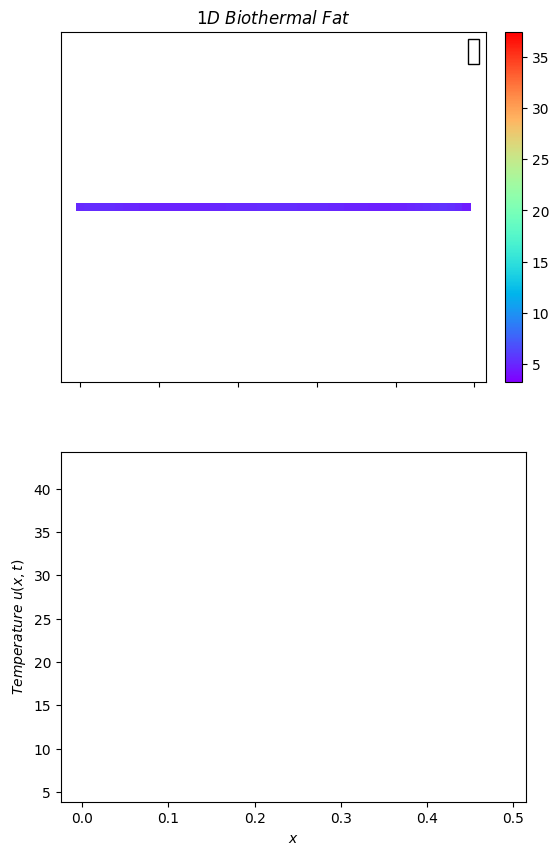

In [ ]:
### plotting

# Define a meshgrid for x and t values
x = np.arange(x_min, x_max, 0.01)
t = np.arange(t_min, t_max, 0.01)

X, T = np.meshgrid(x, t)


# Reshape meshgrid data for collocation points
X = X.reshape(-1, 1)
T = T.reshape(-1, 1)

xt_f = np.hstack([X, T])

# Convert collocation points to PyTorch tensor and move to the specified device
xt_f = torch.tensor(xt_f, dtype=torch.float32).to(device)

# Predict the solution at collocation points using the trained PINN
u_pred = pinn.net(xt_f)
u_pred = u_pred.detach().cpu().numpy()

# Reshape the predicted solution for plotting
u_pred = u_pred.reshape(len(x), len(t), order="F")

# Create a subplot for the 1D Heat Equation
fig, axes = plt.subplots(2, 1, figsize=(6, 10), sharex=True)
bar_x = np.linspace(x_min, x_max, u_pred.shape[0])
bar_y = np.zeros_like(bar_x)

# Plot the initial condition using a scatter plot
axes[0].set_title("$1D\ Biothermal\ Fat$")
axes[0].set_yticks([])

im0 = axes[0].scatter(
    x,
    np.zeros_like(x),
    c=u_pred[:, 0],
    marker="s",
    cmap="rainbow",
    lw=0,
    vmin=u_pred.min() * 1.1,
    vmax=u_pred.max() * 1.1,
)
fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04, extend="neither")
textbox = offsetbox.AnchoredText("", loc=1)
axes[0].add_artist(textbox)

# Plot the temperature evolution over time using a line plot
(im1,) = axes[1].plot([], [], color="k")
axes[1].set_ylim(u_pred.min() * 1.3, u_pred.max() * 1.3)
axes[1].set_xlabel("$x$")
axes[1].set_ylabel("$Temperature\ u(x, t)$")

# Define the update function for animation frames
def update(frame):
  temp = u_pred[:, frame]
  im0.set_array(temp)
  im1.set_data(bar_x, temp)
  textbox = offsetbox.AnchoredText(f"{t[frame]:.2f} sec", loc=1)
  axes[0].add_artist(textbox)

# Create an animation using FuncAnimation
an1 = FuncAnimation(fig, update, frames=len(t), interval=150)

# Display the plot
plt.show()

In [ ]:
an1.save("Fat_heat.gif", dpi=100)

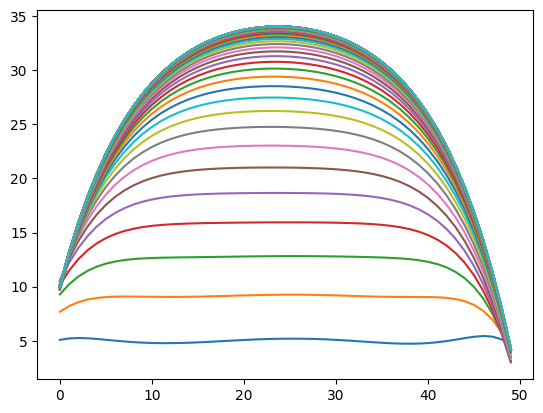

In [ ]:
plt.plot(u_pred)
plt.show()

In [ ]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()
writer.add_graph(pinn.net, xt_f)

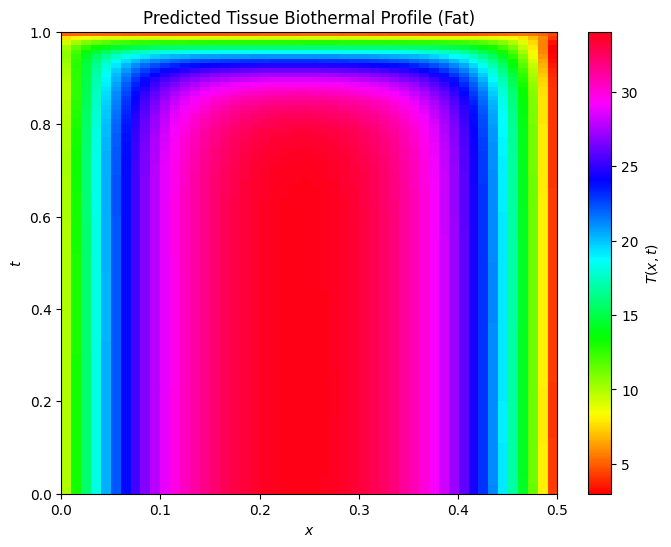

In [ ]:
# Create a subplot for the 1D Heat Equation
fig, axes = plt.subplots(figsize=(8, 6))

# Plot the predicted solution using a 2D surface plot
im = axes.imshow(u_pred.T, extent=[x_min, x_max, t_min, t_max], aspect='auto', cmap='hsv')
axes.set_title('Predicted Tissue Biothermal Profile (Fat)')
axes.set_xlabel('$x$')
axes.set_ylabel('$t$')
fig.colorbar(im, label='$T(x, t)$')

plt.show()